In [1]:
from qtpg.team import Team
from qtpg.learner import Learner
from qtpg.program import Program
from qtpg.rule import Rule
from qtpg.figure13 import Figure13
from qtpg.figure13_hole_in_wall import Figure13HoleInWall
from qtpg.figure12 import Figure12
from qtpg.figure9 import Figure9
from qtpg.figureRandom import FigureRandom
from qtpg.figureHeywood import FigureHeywood
from qtpg.search_manager import SearchManager
import numpy as np
import uuid
import copy
import matplotlib.pyplot as plt

In [2]:
gp_query_env = 0
rl_query_env = 0

In [3]:
# env params
memorySize = 40
legalMove = 0.1
illegalMove = -0.01
outOfBounds = 0.0
memoryRepeat = -0.01
# memoryRepeat = 0.0
goalReached = 100

envName = 'Figure 13'
env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 13 Hole in Wall'
# env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 12'
# env = Figure12(5, 5, (4, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 9'
# env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Heywood'
# env = FigureHeywood(10, 10, (4, 4), (0, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Random'
# env = FigureRandom(20, 20, memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# env.shake(0.2)

In [4]:
# env.save()

In [5]:
# env.load('42b201f5-309e-479c-acb3-52a40f719a3f')

In [6]:
numGens = 100
maxTeamPool = 5
runs = 1
# init search manager and starting teams

# searchManager = SearchManager(maxTeamPool)

# variables for tracking fitness, for curves
scores = []
gens = []
maxes = []
averages = []
mins = []

run_winners = []
runs_score_track = []

for run in range(runs):
    maxes = []
    averages = []
    mins = []
    gens = []
    print(run)
    # init everything for new run
    searchManager = SearchManager(maxTeamPool)
    
    adam_and_eve = []
    env.reset()
#     init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
#     init_team.init_search(env, [2, 3])
#     adam_and_eve.append(init_team)
    init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
    init_team.init_search(env, [0, 1])
    adam_and_eve.append(init_team)
    win = False
    for adam in adam_and_eve:
        data = [adam, win]
        searchManager.evaluate_team(data)
    
    
    for gen in range(numGens):
        print('winners so far:')
        print(searchManager.winners)
        print(f'GEN --> {gen}')
        toEvaluateAfterGen = []
        scores = []
        # get it started
        for parent in searchManager.teamPool:
            # only run if the team has not yet won
            if parent not in searchManager.winners:
                env.current_state = parent.start_state

                # make offspring from parent, then let that offspring make a new rule
                child = copy.deepcopy(parent)
                child.gp_query_env = parent.gp_query_env # probably don't need this, can test later
                child.id = uuid.uuid4()
                win = child.search_no_back_track(env)
                
                if child.mostRecent.program.rule.region[3] - child.mostRecent.program.rule.region[2] >= 0:
                    gp_query_env += (child.mostRecent.program.rule.region[3] - child.mostRecent.program.rule.region[2]) + 1
                toEvaluateAfterGen.append([child, win])
                scores.append(child)
            else:
                scores.append(parent)

        for data in toEvaluateAfterGen:
            searchManager.evaluate_team(data)
        # start: manage fitness curves (at end of gen)
        gens.append(gen)
        total = 0
        max_fitness = -100
        min_fitness = 100

        for team in scores:
            total += team.fitness
            if team.fitness > max_fitness:
                max_fitness = team.fitness
            if team.fitness < min_fitness:
                min_fitness = team.fitness
        average_fitness = total / len(searchManager.teamPool)
        maxes.append(max_fitness)
        averages.append(average_fitness)
        mins.append(min_fitness)

    runs_score_track.append({'run': run, 'maxes': maxes, 'averages': averages, 'mins': mins})
    
    run_winners.append({'run': run, 'winners': searchManager.winners})

0
winners so far:
[]
GEN --> 0
------
4
[0, 1, 0, 2]
------
[0, 1, 0, 2]
winners so far:
[]
GEN --> 1
------
6
[0, 0, 0, 4]
------
[0, 0, 0, 4]
------
4
[1, 0, 0, 1]
------
[1, 0, 0, 1]
winners so far:
[]
GEN --> 2
------
6
[0, 1, 0, 2]
------
[0, 1, 0, 2]
------
3
[1, 1, 0, 1]
------
[1, 1, 0, 1]
------
3
[1, 1, 0, 1]
------
[1, 1, 0, 1]
------
6
[0, 1, 0, 2]
------
[0, 1, 0, 2]
winners so far:
[]
GEN --> 3
------
4
[1, 0, 0, 1]
------
[1, 0, 0, 1]
------
5
[0, 1, 0, 2]
------
[0, 1, 0, 2]
------
4
[1, 0, 0, 1]
------
[1, 0, 0, 1]
------
4
[0, 1, 0, 2]
------
[0, 1, 0, 2]
------
4
[1, 0, 0, 1]
------
[1, 0, 0, 1]
winners so far:
[]
GEN --> 4
------
4
[1, 1, 0, 1]
------
[1, 1, 0, 1]
------
4
[1, 1, 0, 1]
------
[1, 1, 0, 1]
------
6
[0, 1, 0, 2]
------
[0, 1, 0, 2]
------
4
[1, 0, 0, 1]
------
[1, 0, 0, 1]
------
10
[0, 0, 0, 4]
------
[0, 0, 0, 4]
winners so far:
[]
GEN --> 5
------
9
[1, 2, 0, 4]
------
[1, 2, 0, 4]
------
5
[0, 1, 0, 2]
------
[0, 1, 0, 2]
------
6
[0, 0, 0, 4]
---

In [7]:
#fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for average in averages:
#     y.append(average)
# plt.xlabel('Generation')
# plt.ylabel('Average Score')
# plt.plot(x, y)
# plt.show()

In [8]:
# #fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for max_ in maxes:
#     y.append(max_)
# plt.xlabel('Generation')
# plt.ylabel('Max Score')
# plt.plot(x, y)
# plt.show()

In [9]:
for team in searchManager.winners:
    print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
    print(team.fitness)
    print('Learners:')
    for learner in team.learners:
        print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
    print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')

$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$
104.1
Learners:
Region: [1, 0, 0, 0] --> Action: [0, 1]
Region: [0, 1, 1, 2] --> Action: [2, 3]
Region: [1, 0, 0, 0] --> Action: [0, 1]
Region: [0, 1, 1, 2] --> Action: [2, 3]
Region: [1, 0, 1, 1] --> Action: [0, 1]
Region: [0, 0, 1, 4] --> Action: [2, 3]
Region: [1, 0, 1, 1] --> Action: [0, 1]
Region: [0, 0, 0, 1] --> Action: [2, 3]
Region: [0, 0, 3, 4] --> Action: [2, 3]
Region: [1, 2, 0, 3] --> Action: [0, 1]
Region: [0, 4, 0, 3] --> Action: [2, 3]
Region: [1, 4, 2, 4] --> Action: [0, 1]
$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$
105.83999999999999
Learners:
Region: [1, 0, 0, 0] --> Action: [0, 1]
Region: [0, 1, 1, 2] --> Action: [2, 3]
Region: [1, 0, 0, 0] --> Action: [0, 1]
Region: [0, 1, 1, 2] --> Action: [2, 3]
Region: [1, 0, 1, 1] --> Action: [0, 1]
Region: [0, 0, 1, 4] --> Action: [2, 3]
Region: [1, 0, 1, 1] --> Action: [0, 1]
Region: [0, 0, 1, 4] --> Action: [2, 3]
R

In [10]:
for team in searchManager.winners:
    # importing libraries
    from mpl_toolkits import mplot3d
    import numpy as np
    import matplotlib.pyplot as plt

    region_action_scores = []
    for learner in team.learners:
        if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
            region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
        else:
            region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

    sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
    # print(sorted_region_action_scores)
    # for record in sorted_region_action_scores:
    #     print(record)
    action_states = []
    for record in sorted_region_action_scores:
        action = ''
        if record['action'] == 0:
            action = '\u2191'
        elif record['action'] == 1:
            action = '\u2193'
        elif record['action'] == 2:
            action = '\u2192'
        elif record['action'] == 3:
            action = '\u2190'

        for i in range(record['region'][3] - record['region'][2]+1):
            state = [0, 0]
            state[record['region'][0]] = record['region'][1]
            state[not record['region'][0]] = record['region'][2] + i

            # ensure we do not enter duplicate states
            found = 0
            for pair in action_states:
                if pair['state'] == (state[0], state[1]):
                    found = 1

            if found == 0:
                action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

    # add in the rest of the states, either they are not visited, or illegal
    for n in reversed(range(env.rows)):
        for m in range(env.cols):
            action = ''
            found = 0
            for record in action_states:
                if record['state'] == (n, m):
                    found = 1
                    action = record['action']
    #                 action = float(round(record['q'], 0))
            if found == 0:
                if not env.check_legal((n, m)):
                    action = 'X'
                else:
                    action = '?'
            print(f'{action} ', end='')
        print('\n')
    print('------------NEW WINNER ----------------')

← ← ← ← ↓ 

? X ↓ X ↓ 

X X ↓ X ↓ 

↓ ← ← X X 

↓ ← ← ← ← 

------------NEW WINNER ----------------
← ← ↓ ← ↓ 

? X ↓ X ↓ 

X X ↓ X ↓ 

↓ ← ← X X 

↓ ← ← ← ← 

------------NEW WINNER ----------------
← ← ↓ ← ↓ 

? X ↓ X ↓ 

X X ↓ X ↓ 

↓ ← ← X X 

↓ ← ← ← ← 

------------NEW WINNER ----------------
← ← ↓ ← ↓ 

? X ↓ X ↓ 

X X ↓ X ↓ 

↓ ← ← X X 

↓ ← ← ← ← 

------------NEW WINNER ----------------
← ← ↓ ← ↓ 

? X ↓ X ↓ 

X X ↓ X ↓ 

↓ ← ← X X 

↓ ← ← ← ← 

------------NEW WINNER ----------------


## Average Max Fitness Curves

In [11]:
print(runs_score_track[0]['maxes'][0])
print(len(runs_score_track))
print(len(runs_score_track[0]))
print(len(runs_score_track[0]['maxes']))

0.37
1
4
100


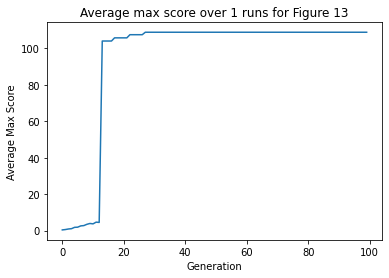

In [12]:
#fitness curves
x = []
y = []
average_maxes = np.zeros(numGens)
# average_maxes = np.zeros(100)

for i in range(len(gens)):
    for q in range(len(runs_score_track)):
        average_maxes[i] += runs_score_track[q]['maxes'][i]
    average_maxes[i] /= len(runs_score_track)
    
for gen in gens:
    x.append(gen)

plt.title(f'Average max score over {len(runs_score_track)} runs for {envName}')
plt.xlabel('Generation')
plt.ylabel('Average Max Score')
plt.plot(x, average_maxes)
plt.show()

## Reinforcement Learning + Victory Lap

In [13]:
print(run_winners)
for winner in run_winners[0]['winners']:
    for learner in winner.learners:
        print(learner.program.rule.region)
    print('\n\n\n')
# for learner in team.learners:
#     print(learner.program.rule.region)

[{'run': 0, 'winners': [<qtpg.team.Team object at 0x7f9801109f40>, <qtpg.team.Team object at 0x7f9801109340>, <qtpg.team.Team object at 0x7f9801109f70>, <qtpg.team.Team object at 0x7f9801112fd0>, <qtpg.team.Team object at 0x7f98010ff460>]}]
[1, 0, 0, 0]
[0, 1, 1, 2]
[1, 0, 0, 0]
[0, 1, 1, 2]
[1, 0, 1, 1]
[0, 0, 1, 4]
[1, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 3, 4]
[1, 2, 0, 3]
[0, 4, 0, 3]
[1, 4, 2, 4]




[1, 0, 0, 0]
[0, 1, 1, 2]
[1, 0, 0, 0]
[0, 1, 1, 2]
[1, 0, 1, 1]
[0, 0, 1, 4]
[1, 0, 1, 1]
[0, 0, 1, 4]
[1, 0, 1, 1]
[0, 0, 1, 4]
[1, 0, 0, 0]
[0, 1, 0, 1]
[1, 2, 0, 0]
[1, 2, 2, 4]
[0, 1, 0, 1]
[1, 2, 0, 3]
[0, 4, 0, 3]
[1, 4, 2, 4]




[1, 0, 0, 0]
[0, 1, 1, 2]
[1, 0, 0, 0]
[0, 1, 1, 2]
[1, 0, 1, 1]
[0, 0, 1, 4]
[1, 0, 1, 1]
[0, 0, 1, 4]
[1, 0, 1, 1]
[0, 0, 1, 4]
[1, 0, 0, 0]
[0, 1, 0, 1]
[1, 2, 0, 0]
[1, 2, 2, 4]
[0, 1, 0, 1]
[1, 2, 1, 4]
[0, 0, 0, 1]
[0, 0, 3, 4]
[1, 2, 0, 0]
[1, 2, 2, 4]
[0, 1, 0, 1]
[1, 2, 0, 3]
[0, 4, 0, 3]
[1, 4, 2, 4]




[1, 0, 0, 0]
[0, 1, 1, 2]
[1, 0, 0, 0]
[0, 1,

In [14]:
for i in range(len(run_winners[0]['winners'])):
    for learner in run_winners[0]['winners'][i].learners:
        print(learner.id)
    print('\n')

aa84ed01-bd3f-40c8-9138-11bc09f68fd1
c3beb6a4-bacc-4f30-9b65-8fdb952f8dc6
46b0b2d0-4c6d-4021-a488-c2686241cd51
589842a7-bbbf-4bf2-930a-a46f157780e9
a1889c16-ac74-4222-b2b6-cc3fc4bd3a53
3109b215-05f8-497f-8586-ac4cc58ef884
0b83d20d-e336-4bd0-be08-5f8a4c27c1c8
921ee3b5-c6b0-42d3-afaf-7e87def16249
73455daa-9235-468c-9b9a-661da011d99c
17e286ee-da23-46fe-b8e0-26a0fbc054b1
bb37e699-6a8b-4c7b-a56f-f830945e5560
7c6c5800-d1dc-40a4-a2c6-855b6d658984


aa84ed01-bd3f-40c8-9138-11bc09f68fd1
c3beb6a4-bacc-4f30-9b65-8fdb952f8dc6
46b0b2d0-4c6d-4021-a488-c2686241cd51
589842a7-bbbf-4bf2-930a-a46f157780e9
a1889c16-ac74-4222-b2b6-cc3fc4bd3a53
3109b215-05f8-497f-8586-ac4cc58ef884
0b83d20d-e336-4bd0-be08-5f8a4c27c1c8
921ee3b5-c6b0-42d3-afaf-7e87def16249
0f9afc2e-4012-4115-a767-08e3ac3e55d6
74624cfc-623e-4c31-a070-3a15c2df23f0
cd0b687b-73cd-4bdf-85c8-30b43baecd2d
849dff9a-34d5-48a0-9814-2fd671a86e8e
74bc36e9-ca66-4c01-a6e0-5fe7791133ba
1d54cc74-9048-4f12-b92c-d9b2c5556bfe
c8e2d4b5-d253-400b-b12d-635d517f736e

In [15]:
# team = searchManager.winners[0]
team = run_winners[0]['winners'][0]
team.discount = 0.9
team.alpha = 0.5
# for learner in team.learners:
#     print(learner.program.rule.region)

# team.prune_single_cell_regions() # don't think this is good...
team.prune_duplicate_regions()

illegal_states = [(2, 0), (2, 1), (3, 1), (1, 3), (2, 3), (3, 3), (1, 4)]

for i in range(env.rows):
#     print(f'Epoch: {i+1} --------')
#     env.reset()
    current_state = (0, 0)
#     print(f'curr -> {env.current_state}')
    win = False
    selected_learner = team.select_learner(current_state, [0, 0, 0, 0])
    while not win:
#         win, needs_update, reward, winning_action = team.q_evaluation(env, selected_learner)
        win, needs_update, reward, winning_action, current_state = team.q_evaluation(current_state, selected_learner, illegal_states)
        if not win:
            selected_learner = team.select_learner(current_state, selected_learner.program.rule.region)
            print(f'curr: {current_state}')
            print(f'update: {needs_update}')
            print(f'selected: {selected_learner}')
            team.transition_update(reward, winning_action, needs_update, selected_learner)
            rl_query_env += 1

    team.final_update(reward, winning_action, needs_update)

print(win)
for learner in team.learners:
    print(f'{learner.program.rule.region}')
    for i in range(len(learner.program.rule.action_set)):
          print(f'{learner.program.rule.action_set[i]} --> {learner.program.rule.value_set[i]}')

[1, 0, 0, 0] --> [0, 1]
[1, 0, 0, 0] --> [0, 1]
[0, 0, 0, 1] --> [2, 3]
value set is 0, action selected --> 0
Winning action: 0
[1, 0, 1, 1] --> [0, 1]
[1, 0, 1, 1] --> [0, 1]
curr: (1, 0)
update: <qtpg.learner.Learner object at 0x7f98010d2760>
selected: <qtpg.learner.Learner object at 0x7f9801103f40>
value set is 0, action selected --> 0
Winning action: 0
eek!
curr: (2, 0)
update: <qtpg.learner.Learner object at 0x7f9801103f40>
selected: None


AttributeError: 'NoneType' object has no attribute 'program'

## State Action Map (RL)

In [ ]:
# importing libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
# print(sorted_region_action_scores)
# for record in sorted_region_action_scores:
#     print(record)
action_states = []
for record in sorted_region_action_scores:
    action = ''
    if record['action'] == 0:
        action = '\u2191'
    elif record['action'] == 1:
        action = '\u2193'
    elif record['action'] == 2:
        action = '\u2192'
    elif record['action'] == 3:
        action = '\u2190'

    for i in range(record['region'][3] - record['region'][2]+1):
        state = [0, 0]
        state[record['region'][0]] = record['region'][1]
        state[not record['region'][0]] = record['region'][2] + i
        
        # ensure we do not enter duplicate states
        found = 0
        for pair in action_states:
            if pair['state'] == (state[0], state[1]):
                found = 1
                
        if found == 0:
            action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

# add in the rest of the states, either they are not visited, or illegal
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['action']
#                 action = float(round(record['q'], 0))
        if found == 0:
            if not env.check_legal((n, m)):
                action = 'X'
            else:
                action = '?'
        print(f'{action} ', end='')
    print('\n')
    

q_map = np.zeros((env.rows, env.cols))

# add in the rest of the states, either they are not visited, or illegal
for n in range(env.rows):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['q']
        if found == 0:
            if not env.check_legal((n, m)):
                action = -1
            else:
                action = 0
        q_map[(env.rows-1)-n][m] = action

plt.imshow(q_map, cmap='Blues', interpolation='nearest')
plt.show()

x = []
y = []
for i in range(env.cols):
    x.append(i)
    y.append(i)

Y, X = np.meshgrid(x, y)

fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection ='3d')

# syntax for plotting
ax.plot_surface(X, Y, q_map, cmap ='viridis', edgecolor ='green')
ax.set_title(f'Surface plot for {envName}')
plt.show()

## Heatmap (RL)

In [ ]:
region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)

state_counts = []

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        state_count = 0
        for record in sorted_region_action_scores:
            for i in range(record['region'][3] - record['region'][2]+1):
                state = [0, 0]
                state[record['region'][0]] = record['region'][1]
                state[not record['region'][0]] = record['region'][2] + i

                if state == [n, m]:
                    state_count += 1
                # state count logic goes here
        state_counts.append({'state': (n, m), 'count': state_count})

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        for record in state_counts:
            if (n, m) == record['state']:
                count = record['count']
                print(f'{count} ', end='')
    print('')

In [ ]:
# print(team.gp_query_env)
print(gp_query_env)
print(rl_query_env)